In [1]:
using AutomotiveDrivingModels
using AutoViz
using Reactive
using Interact

#import PyPlot

# Types

In [2]:
type HRHC # Hierarchical Receding Horizon Controller
    v_cmds # possible velocity commands
    δ_cmds # possible δ_cmds
    ΔXYθ # state changes associated with cmd = (v_command, δ_command)
    legal_ΔXYθ # reachable from current v, δ
    legal_v # reachable from current v, δ
    legal_δ # reachable from current v, δ
    v_idx_low::Int # index lowest reachable v_command
    v_idx_high::Int # index highest reachable v_command
    δ_idx_low::Int # index lowest reachable δ_command
    δ_idx_high::Int # index highest reachable δ_command
    successor_states # reachable next_states
    
    #car parameters with bicycle geometry model
    car_length::Float64
    car_width::Float64
    car_ID::Int
    
    # current v, current δ
    v::Float64
    δ::Float64
    
    # planning horizon
    h::Int
    Δt::Float64
    
    # reachable range of V and δ within a single time step
    ΔV₊::Float64
    ΔV₋::Float64
    Δδ::Float64
    
    V_MIN::Float64
    V_MAX::Float64
    V_STEPS::Int
    δ_MAX::Float64
    δ_MIN::Float64
    δ_STEPS::Int

    # maximum deviation from center of track (if |t| > T_MAX, car is out of bounds)
    T_MAX::Float64
    
    function HRHC(car_ID::Int;
        car_length::Float64=4.8,
        car_width::Float64=1.8,
        v::Float64=0.0,
        δ::Float64=0.0,
        h::Int=10,
        Δt::Float64=1.0/24,
        ΔV₊::Float64=1.55/100,
        ΔV₋::Float64=3.05/100,
        Δδ::Float64=Float64(π)/16,
        V_MIN::Float64=0.0,
        V_MAX::Float64=100.0,
        V_STEPS::Int=101,
        δ_MAX::Float64=Float64(π)/8,
        δ_MIN::Float64=-Float64(π)/8,
        δ_STEPS::Int=16,
        )
        
        hrhc = new()
        
        hrhc.V_MIN=V_MIN
        hrhc.V_MAX=V_MAX
        hrhc.V_STEPS=V_STEPS
        hrhc.δ_MAX=δ_MAX
        hrhc.δ_MIN=δ_MIN
        hrhc.δ_STEPS=δ_STEPS
        
        hrhc.car_ID = car_ID
        hrhc.car_length=car_length
        hrhc.car_width=car_width
        hrhc.h=h
        hrhc.Δt=Δt
        hrhc.ΔV₊=ΔV₊
        hrhc.ΔV₋=ΔV₋
        hrhc.Δδ=Δδ
        
        hrhc.v_cmds, hrhc.δ_cmds, hrhc.ΔXYθ = MotionPrimitives(car_length,car_width,h,Δt,V_MIN,V_MAX,V_STEPS,δ_MAX,δ_MIN,δ_STEPS)
        QuadraticMask!(hrhc.ΔXYθ)
        
        hrhc.v=v
        hrhc.δ=δ
        
        hrhc
    end
end

In [3]:
type ObstacleMap
    IDs
    coords
    proximity_array
    proximity_kernel
    
    function ObstacleMap(IDs, scene::Scene)
        retval = new()
        
        retval.IDs = IDs
        retval.coords = zeros(3, length(IDs))
        for i in 1:length(IDs)
            pos = scene.vehicles[obstacle_IDs[i]].state.posG
            retval.coords[1,i] = pos.x
            retval.coords[2,i] = pos.y
            retval.coords[3,i] = pos.θ
        end
        
        # initialize proximity kernel - indicator for whether an agent needs to plan against a given obstacle
        retval.proximity_array = zeros(2,size(retval.coords,2)) # Δr, Δθ
        retval.proximity_kernel = zeros(1,size(retval.proximity_array,2)) # 1[within_planning_horizon]
        
        retval
    end
    
    function ObstacleMap(count::Int, scene::Scene)
        retval = new()
        
        retval.IDs = []
        L = length(scene)
        for j in 1+L:count+L
            push!(retval.IDs, j)
            ind_i = rand([i for i in 1:25])
            ind_t = rand([i/100.0 for i in 1:100])
            t = rand([i/10.0 for i in -10:10])*lane_width/2.0
            ϕ = rand([i/20.0 for i in -20:20])*Float64(π)
            segment = rand([i for i in 1:4])
            roadind = RoadProjection(CurveProjection(CurveIndex(ind_i, ind_t), t, ϕ), LaneTag(segment,1))
            vehstate = VehicleState(Frenet(roadind, roadway), roadway, 0.0)
            vehdef = VehicleDef(j, AgentClass.CAR, 4.8, 1.8)
            push!(scene, Vehicle(vehstate, vehdef))
        end
        
        retval.coords = zeros(3, length(retval.IDs))
        for i in 1:length(retval.IDs)
            pos = scene.vehicles[retval.IDs[i]].state.posG
            retval.coords[1,i] = pos.x
            retval.coords[2,i] = pos.y
            retval.coords[3,i] = pos.θ
        end
        
        # initialize proximity kernel - indicator for whether an agent needs to plan against a given obstacle
        retval.proximity_array = zeros(2,size(retval.coords,2)) # Δr, Δθ
        retval.proximity_kernel = zeros(1,size(retval.proximity_array,2)) # 1[within_planning_horizon]
        
        retval
    end
    
end

# utility functions

In [4]:
# Return a library of motion primitives (arcs of constant radius) representing short paths that the car can follow.
function MotionPrimitives(car_length,car_width,h,Δt,v_min,v_max,v_steps,δ_max,δ_min,δ_steps)
    # 3D array to store motion_primitives
    motion_primitives = zeros(v_steps,2*δ_steps+1,2) # v: 0,...,99; δ: -45:45, (arc length, +/- radius)

    v = linspace(v_min,v_max,v_steps)*ones(1,2*δ_steps+1)
    δ = (linspace(-δ_max,δ_max,δ_steps*2+1)*ones(1,v_steps))' # steering angle

    motion_primitives[:,:,1] = v*Δt*h # arc length = velocity * time
    motion_primitives[:,:,2] = car_length./sin(δ) # radius of curvature (+ or -)
    motion_primitives[:,1+δ_steps,2] = Inf; # radius of curvature is infinite if steering angle = 0
    
    destination_primitives = zeros(v_steps,2*δ_steps+1,h,3) # lookup table defining car's location at each of next h time steps

    for i = 1:h
        # angle = 2π * arc_length / r
        dθ = v*Δt*i ./ motion_primitives[:,:,2]
        
        # dX = abs(radius) * sin(angle)
        destination_primitives[:,:,i,1] = abs(motion_primitives[:,:,2]) .* sin(abs(dθ))
        destination_primitives[:,1+δ_steps,i,1] = v[:,1+δ_steps]*Δt*i # centerline
        
        # dY = radius * (1 - cos(angle))
        destination_primitives[:,:,i,2] = motion_primitives[:,:,2].*(1 - cos(dθ))
        destination_primitives[:,1+δ_steps,i,2] = 0 # centerline
        
        destination_primitives[:,:,i,3] = dθ
    end
    
    # motion_primitives[v, δ, i,j] = s (arc_length), r (radius of curvature)
    # destination_primitives[v, δ, h, 1=Δx,2=Δy,3=Δθ]= changes in x, y and θ after h time steps
    return v, δ, destination_primitives

end

MotionPrimitives (generic function with 1 method)

In [5]:
# quadratic logical mask
function QuadraticMask!(library)
    A = size(library)[1]
    B = size(library)[2]
    X = linspace(0,99,A)*ones(1,B)
    Y = ones(A,1)*linspace(-20,20,B)'
    f = 24*Y.^2 + X.^2
    mask = 1.0*(f.<10000)
    
#     fig = figure()
#     ax = gca()
#     p = scatter(X,Y.*mask)
#     xlabel("velocity")
#     ylabel("steering angle")
#     fig[:canvas][:draw]()

    if length(size(library)) == 3
        for i in 1 : size(library)[3]
            library[:,:,i] = library[:,:,i] .* mask
        end
    end
    if length(size(library)) == 4
        for i in 1 : size(library)[3]
            for j in 1 : size(library)[4]
                library[:,:,i,j] = library[:,:,i,j] .* mask
            end
        end
    end
end

QuadraticMask! (generic function with 1 method)

In [6]:
function CurveDist(pt1::CurvePt, pt2::CurvePt)
    Δx = pt1.pos.x - pt2.pos.x
    Δy = pt1.pos.y - pt2.pos.y
    d = sqrt(Δx^2 + Δy^2)
    d
end

CurveDist (generic function with 1 method)

In [7]:
function wrap_to_π(θ)
    θ = θ + (θ .< -π).*(2*Float64(π)) - (θ .> π).*(2*Float64(π)) 
end

wrap_to_π (generic function with 1 method)

In [8]:
# generate distance map - it works!
function GenerateDistanceMap(roadway)
    s = Dict() # current s
    for i in 1:length(roadway.segments)
        seg = roadway.segments[i]
        s[i] = Dict()
        for j in 0:length(seg.lanes[1].curve)
            #s[i][j] = (starting s at pt, distance to next pt)
            if j == 0
                if i == 1
                    s[i][j] = (0, CurveDist(roadway[seg.lanes[1].entrances[1].target], seg.lanes[1].curve[1]))
                else
                    s[i][j] = (s[i-1][length(roadway.segments[i-1].lanes[1].curve)][1] + s[i-1][length(roadway.segments[i-1].lanes[1].curve)][2], 0)
                end
            elseif j != length(seg.lanes[1].curve)
                s[i][j] = (s[i][j-1][1]+s[i][j-1][2], seg.lanes[1].curve[j+1].s - seg.lanes[1].curve[j].s)
            else
                s[i][j] = (s[i][j-1][1]+s[i][j-1][2], CurveDist(roadway[seg.lanes[1].exits[1].target], seg.lanes[1].curve[end]))
            end
        end
    end
    s
end

GenerateDistanceMap (generic function with 1 method)

# HRHC Algorithm

### 0. Initialize motion primitives

### 1. Identify eligible (reachable) motion primitives based on current state

In [9]:
function getLegalMoves!(hrhc::HRHC, scene; h=hrhc.h)
    v_norm = scene.vehicles[hrhc.car_ID].state.v / hrhc.V_MAX

    # Restrict search space to reachable states
    hrhc.v_idx_low = max(1, round(Int,(v_norm - hrhc.ΔV₋)*hrhc.V_STEPS)) # index of lowest reachable v in the next time step
    hrhc.v_idx_high = min(hrhc.V_STEPS, round(Int, (v_norm + hrhc.ΔV₊)*hrhc.V_STEPS)) # highest reachable v in the next time step

    # Restrict search space to reachable states
    hrhc.δ_idx_low = max(1, (hrhc.δ_STEPS+1) + round(Int,((hrhc.δ - hrhc.Δδ)/(hrhc.δ_MAX - hrhc.δ_MIN))*(2*hrhc.δ_STEPS+1)))
    hrhc.δ_idx_high = min((2*hrhc.δ_STEPS+1), (hrhc.δ_STEPS+1) + round(Int,((hrhc.δ + hrhc.Δδ)/(hrhc.δ_MAX - hrhc.δ_MIN))*(2*hrhc.δ_STEPS+1)))

    # legal_moves = motion_primitives[v_idx_low:v_idx_high,δ_idx_low:δ_idx_high,:]
    hrhc.legal_ΔXYθ = hrhc.ΔXYθ[hrhc.v_idx_low:hrhc.v_idx_high,hrhc.δ_idx_low:hrhc.δ_idx_high,h,:] # ΔX, ΔY, Δθ
    hrhc.legal_v = hrhc.v_cmds[hrhc.v_idx_low:hrhc.v_idx_high,hrhc.δ_idx_low:hrhc.δ_idx_high]
    hrhc.legal_δ = hrhc.δ_cmds[hrhc.v_idx_low:hrhc.v_idx_high,hrhc.δ_idx_low:hrhc.δ_idx_high]
    
    return
end

getLegalMoves! (generic function with 1 method)

### 2. Calculate resulting final state (posG) from applying each given motion primitive

In [10]:
#function getSuccessorStates(vehicle, hrhc)
function getSuccessorStates!(hrhc::HRHC, scene::Scene)
    pos = scene.vehicles[hrhc.car_ID].state.posG # global x,y,z of car

    ΔX = hrhc.legal_ΔXYθ[:,:,1] * cos(pos.θ) + hrhc.legal_ΔXYθ[:,:,2] * -sin(pos.θ)
    ΔY = hrhc.legal_ΔXYθ[:,:,1] * sin(pos.θ) + hrhc.legal_ΔXYθ[:,:,2] * cos(pos.θ)
    Δθ = hrhc.legal_ΔXYθ[:,:,3]

    hrhc.successor_states = zeros(size(hrhc.legal_ΔXYθ))
    hrhc.successor_states[:,:,1] = ΔX + pos.x
    hrhc.successor_states[:,:,2] = ΔY + pos.y
    hrhc.successor_states[:,:,3] = wrap_to_π(Δθ + pos.θ)
    
    return
end

getSuccessorStates! (generic function with 1 method)

### 3. Project posG onto track to determine if a given motion is legal (in bounds)

In [11]:
function projectGridToCenterline(hrhc::HRHC, roadway, sMap)
    s = zeros(size(hrhc.successor_states[:,:,1]))
    t = zeros(size(s))
    ϕ = zeros(size(s))
    tag = zeros(size(s))

    successor_states_grid = reshape(hrhc.successor_states, length(hrhc.successor_states[:,:,1]),3) # must reshape to index correctly

    for i in 1 : length(s)
        myProj = Vec.proj(VecSE2(successor_states_grid[i,:]), roadway) # project point onto roadway
        curve = myProj.curveproj
        tag[i] = myProj.tag.segment
        s[i] = sMap[tag[i]][curve.ind.i][1] + sMap[tag[i]][curve.ind.i][2]*curve.ind.t # total distance traveled
        t[i] = curve.t # distance from centerline
        ϕ[i] = curve.ϕ
    end
    
    # account for returning to the beginning of the roadway (leaving last segment, entering first segment)
    if maximum(tag) == length(roadway.segments) && minimum(tag) == 1
        tag_filter = (tag .== minimum(tag))
        s += sMap[length(roadway.segments)][length(roadway.segments[end].lanes[1].curve)][1].*tag_filter
    end
    
    return s,t,ϕ
end

projectGridToCenterline (generic function with 1 method)

### 4. Select legal motion primitive that yields highest progress

### 5. Check each time step up to horizon to make sure the entire trajectory is legal

In [12]:
function applyObstacleKernel!(arr, obstacle_ID, hrhc, scene, roadway)
    """
    computes a penalty function over hrhc.successor_states to penalize which
    successor states will result in a collision with the obstacle
    """
    
    pos = scene.vehicles[obstacle_ID].state.posG # position of obstacle
    x = pos.x
    y = pos.y
    
    r = sqrt((hrhc.successor_states[:,:,1] - x).^2 + (hrhc.successor_states[:,:,2] - y).^2)
    
    kernel = 1.0*(r .> hrhc.car_length)
    arr = arr .* kernel
end

applyObstacleKernel! (generic function with 1 method)

In [13]:
function computeTrajectory(hrhc::HRHC, scene, cmd_index; h=hrhc.h)
    pos = scene.vehicles[hrhc.car_ID].state.posG
    
    traj_ΔXYθ = hrhc.ΔXYθ[cmd_index[1],cmd_index[2],1:h,:]
    
    ΔX = traj_ΔXYθ[:,1] * cos(pos.θ) + traj_ΔXYθ[:,2] * -sin(pos.θ)
    ΔY = traj_ΔXYθ[:,1] * sin(pos.θ) + traj_ΔXYθ[:,2] * cos(pos.θ)
    Δθ = traj_ΔXYθ[:,3]

    trajectory = zeros(size(traj_ΔXYθ))
    trajectory[:,1] = ΔX + pos.x
    trajectory[:,2] = ΔY + pos.y
    trajectory[:,3] = Δθ + pos.θ
    
    return trajectory
end

computeTrajectory (generic function with 1 method)

In [14]:
function screenTrajectory(trajectory, roadway, hrhc)
    out_of_bounds = false
    
    for i in 1 : size(trajectory,1)
        myProj = Vec.proj(VecSE2(trajectory[i,:]), roadway) # project point onto roadway
        t = myProj.curveproj.t
        if abs(t) > hrhc.T_MAX
            #print("T OUT OF BOUNDS!!!")
            out_of_bounds=true
            return out_of_bounds
        end
    end
    return out_of_bounds
end

screenTrajectory (generic function with 1 method)

### 6. Apply the motion primitive for a single time step

### 7. Go back to 1

# get HRHC action function

In [15]:
function get_HRHC_action(hrhc::HRHC, roadway, scene, sMap, obstacles::ObstacleMap)
    # get current state
    state = scene.vehicles[hrhc.car_ID].state
    v = state.v # current v
    hrhc.v = v
    
    action_selected = false
    trajectory = zeros(3,hrhc.h)
    abs_cmd = (0,0)
    
    i = 0
    for i in 0:(hrhc.h-1)
        if action_selected
            break # out of for loop
        end
        
        # get legal (reachable from current v, δ) actions
        getLegalMoves!(hrhc, scene, h=hrhc.h-i)
        
        # calculate successor states
        getSuccessorStates!(hrhc, scene)
        
        # project successor states onto track
        s,t,ϕ = projectGridToCenterline(hrhc, roadway, sMap)
        
        # remove actions that lead to running out of bounds
        t_filter = (abs(t) .< hrhc.T_MAX)
        eligible_s = s .* t_filter
        
        # update obstacle kernel - maybe use reactive programming here (in the future)
        x = state.posG.x
        y = state.posG.y
        θ = state.posG.θ
        obstacles.proximity_array[1,:] = sqrt((obstacles.coords[1,:] - x).^2 + (obstacles.coords[2,:] - y).^2) # radius
        obstacles.proximity_array[2,:] = wrap_to_π(atan2(obstacles.coords[2,:]-y, obstacles.coords[1,:]-x) - θ) # angle
        obstacles.proximity_kernel[1,:] = obstacles.proximity_array[1,:] .< v*hrhc.Δt*hrhc.h # only test against obstacles within horizon
        obstacles.proximity_kernel[1,:] = obstacles.proximity_kernel[1,:].*(abs(obstacles.proximity_array[2,:]) .< Float64(π)/2) # only test against obstacles ahead of vehicle
        
        # apply obstacle kernel
        if sum(obstacles.proximity_kernel) > 0
            for i in length(obstacles.IDs)
                if obstacles.proximity_kernel[i] > 0
                    applyObstacleKernel!(eligible_s, obstacles.IDs[i], hrhc, scene, roadway)
                end
            end
        end
        
        # select command expected to yield highest forward progress
        ######################## OPTIMIZE #########################
        while (action_selected==false) && (sum(t_filter) > 0)
            index = indmax(eligible_s) # find get a better method of optimizing this
            cmd = ind2sub(eligible_s, index)
            abs_cmd = (cmd[1]+hrhc.v_idx_low-1, cmd[2]+hrhc.δ_idx_low-1)

            # compute full trajectory up to horizon
            trajectory = computeTrajectory(hrhc, scene, abs_cmd, h=hrhc.h-i)
            
            # screen trajectory for collisions / validity
            out_of_bounds = screenTrajectory(trajectory, roadway, hrhc)  
            if out_of_bounds
                t_filter[index] = 0
                eligible_s[index] = 0
            else
                action_selected=true
            end
        end
        
        
    end

    
    next_state = VehicleState(VecSE2(trajectory[1,:]),roadway,hrhc.v_cmds[abs_cmd[1], abs_cmd[2]])
    action = NextState(next_state)
    
    hrhc.δ = hrhc.δ_cmds[abs_cmd[1], abs_cmd[2]]
    hrhc.v = hrhc.v_cmds[abs_cmd[1], abs_cmd[2]]
    
    return action
    
end

get_HRHC_action (generic function with 1 method)

## Initialize Parameters

In [16]:
# scene parameters
scene = Scene()
framerate = 24
Δt = 1.0/framerate # size of rendering timesteps
n_integration_sub_steps = 3 # sub steps for smoother integration
context = IntegratedContinuous(Δt, n_integration_sub_steps) # integrated continuous context

models = Dict{Int, DriverModel}()
carcolors = Dict{Int, Colorant}()

#car parameters
car_length = 4.8 # front wheel to back wheel
car_width = 2.5
v⁰  = 0.0 # initial velocity
δ⁰ = 0.0 # initical steering angle

#controller parameters
h = 10 # look-ahead horizon
V_MIN = 0.0 # mininmum velocity (m/s)
V_MAX = 80.0 # maximum velocity (m/s)
V_STEPS = 101 # resolution of velocity
δ_MAX = Float64(π)/8 # max steering angle (radians)
δ_MIN = -δ_MAX # min steering angle (radians)
δ_STEPS = 16 # resolution of steering angle
ΔV₊ = 1.55 / V_MAX
ΔV₋ = 3.05 / V_MAX
Δδ = Float64(π)/16

0.19634954084936207

In [17]:
############### INITIALIZE TRACK ################

lane_width = 8.0*DEFAULT_LANE_WIDTH
radius = 45.0
edge_buffer = 0.25
T_MAX = lane_width/2.0 - car_width/2.0 - edge_buffer # max allowable projection distance from center of lane
base_speed= 0.0

roadway = gen_stadium_roadway(1, radius=radius, lane_width=lane_width)
roadind1 = RoadIndex(proj(VecSE2(0.0,-1*DEFAULT_LANE_WIDTH,0.0), roadway))
roadind2 = RoadIndex(proj(VecSE2(40.0,-1*DEFAULT_LANE_WIDTH,0.0), roadway))

vehstate1 = VehicleState(Frenet(roadind1, roadway), roadway, base_speed+randn())
vehstate2 = VehicleState(Frenet(roadind2, roadway), roadway, base_speed+randn())

vehdef1 = VehicleDef(1,AgentClass.CAR, 4.8, 1.8)
vehdef2 = VehicleDef(2,AgentClass.CAR, 4.8, 1.8)

push!(scene,Vehicle(vehstate1, vehdef1))
# push!(scene,Vehicle(vehstate2, vehdef2)) # car 2

models[1] = Tim2DDriver(context, rec=SceneRecord(1, context.Δt, 1))
# models[2] = Tim2DDriver(context, rec=SceneRecord(1, context.Δt, 1))
actions = Array(DriveAction, length(scene))

1-element Array{AutomotiveDrivingModels.DriveAction,1}:
 #undef

In [18]:
############# INITIALIZE OBSTACLES ##############

count = 6
obstacles = ObstacleMap(count,scene)

ObstacleMap(Any[2,3,4,5,6,7],[-36.1542 -48.77 … -11.7474 110.566; 60.5564 34.9669 … 90.9139 -2.41511; 3.93157 5.07236 … 5.81391 1.31881],[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0],[0.0 0.0 … 0.0 0.0])

In [19]:
################################################

carcolors[1] = colorant"red"
# carcolors[2] = colorant"blue"

# generate distance map
sMap = GenerateDistanceMap(roadway)

Dict{Any,Any} with 4 entries:
  4 => Dict{Any,Any}(Pair{Any,Any}(18,(482.127,2.94524)),Pair{Any,Any}(2,(435.0…
  2 => Dict{Any,Any}(Pair{Any,Any}(18,(230.755,2.94524)),Pair{Any,Any}(2,(183.6…
  3 => Dict{Any,Any}(Pair{Any,Any}(18,(401.441,2.94524)),Pair{Any,Any}(2,(354.3…
  1 => Dict{Any,Any}(Pair{Any,Any}(18,(150.069,2.94524)),Pair{Any,Any}(2,(102.9…

In [20]:
############# INITIALIZE CONTROLLERS ##############

car1 = HRHC(1)
# car2 = HRHC(2)
car1.T_MAX=T_MAX
# car2.T_MAX=T_MAX

10.5

# Run HRHC:

In [21]:
function drawsim(t, dt=NaN)
    actions[car1.car_ID] = get_HRHC_action(car1, roadway, scene, sMap, obstacles)
#     actions[car2.car_ID] = get_HRHC_action(car2, roadway, scene, sMap)
    tick!(scene, roadway, actions, models)
    render(scene, roadway, cam=FitToContentCamera(), car_colors=carcolors)
#     render(scene, roadway, cam=CarFollowCamera(1, 15.0), canvas_height=300)
end

drawsim (generic function with 2 methods)

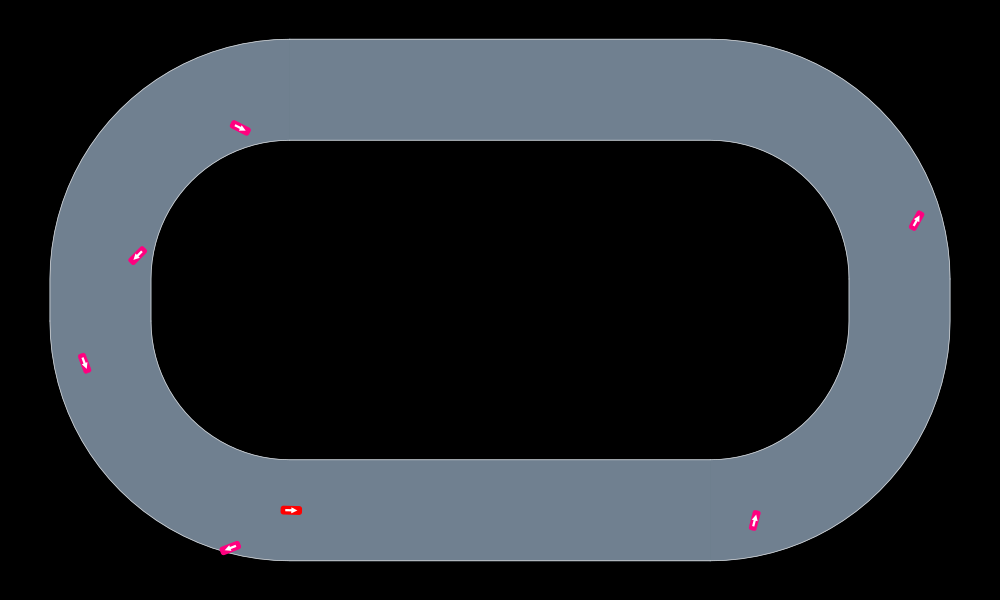

In [22]:
ticks = fps(framerate)
timestamps = map(_ -> time(), ticks)
map(drawsim, timestamps)

In [ ]:
s,t,ϕ = projectGridToCenterline(car1, roadway, sMap)

# remove actions that lead to running out of bounds
t_filter = (abs(t) .< car1.T_MAX)
eligible_s = s .* t_filter
eligible_s

In [ ]:
# update obstacle kernel - maybe use reactive programming here (in the future)
x = scene.vehicles[car1.car_ID].state.posG.x
y = scene.vehicles[car1.car_ID].state.posG.y
θ = scene.vehicles[car1.car_ID].state.posG.θ
v = scene.vehicles[car1.car_ID].state.v
obstacles.proximity_array[1,:] = sqrt((obstacles.coords[1,:] - x).^2 + (obstacles.coords[2,:] - y).^2) # radius
obstacles.proximity_array[2,:] = wrap_to_π(atan2(obstacles.coords[2,:]-y, obstacles.coords[1,:]-x) - θ) # angle
obstacles.proximity_kernel[1,:] = obstacles.proximity_array[1,:] .< v*car1.Δt*car1.h # only test against obstacles within horizon
obstacles.proximity_kernel[1,:] = obstacles.proximity_kernel[1,:].*(abs(obstacles.proximity_array[2,:]) .< Float64(π)/2) # only test against obstacles ahead of vehicle

# apply obstacle kernel
if sum(obstacles.proximity_kernel) > 0
    for i in length(obstacles.IDs)
        if obstacles.proximity_kernel[i] > 0
            print(i)
            applyObstacleKernel!(eligible_s, obstacles.IDs[i], car1, scene, roadway)
        end
    end
end

In [ ]:
pos = scene.vehicles[obstacles.IDs[6]].state.posG # position of obstacle
x = pos.x
y = pos.y

r = sqrt((car1.successor_states[:,:,1] - x).^2 + (car1.successor_states[:,:,2] - y).^2)

In [ ]:
kernel = 1.0*(r .> hrhc.car_length)
arr = arr .* kernel

# Testing

In [ ]:
# static vehicles are obstacles on race course
static_vehicles = Set()

roadind1 = RoadIndex(proj(VecSE2(0.0,0,0.0), roadway))
roadind2 = RoadIndex(proj(VecSE2(40.0,0,0.0), roadway))

vehstate1 = VehicleState(Frenet(roadind1, roadway), roadway, base_speed+randn())
vehstate2 = VehicleState(Frenet(roadind2, roadway), roadway, base_speed+randn())

vehdef1 = VehicleDef(1,AgentClass.CAR, 4.8, 1.8)
vehdef2 = VehicleDef(2,AgentClass.CAR, 4.8, 1.8)


## Visualization stuff

In [ ]:
# Visualize motion primitives
xgrid = linspace(V_MIN,V_MAX,V_STEPS)*ones(1,2*δ_STEPS+1)
ygrid = (linspace(-δ_MAX,δ_MAX,δ_STEPS*2+1)*ones(1,V_STEPS))' # steering angle
z = ΔXYθ[:,:,10,1]

PyPlot.plot_surface(xgrid, ygrid, z, rstride=1,edgecolors="k", cstride=1,
    alpha=0.8, linewidth=0.25)

# Features to add

In [ ]:
"""
##########
Optimization Objective Function
- requires more correct measure of arc length s
- reward progress on track
- penalize heuristic functions of ϕ, t
--- f(ϕ,t) to penalize steering away from centerline?

##########
ProximityKernel(): gives proximity to a given location against a set of locations that represent obstacles
proximity = ProximityKernel(X,Y,θ,(ObstacleCoords))
proximity = ProximityKernel(s,t,ϕ,(ObstaclesCoords))

##########
Array-based operations for a faster and more robust search through eligible motion primitives
- Search highest V candidates first
- break out of a candidate trajectory as soon as ineligible
- If no trajectory is feasible, restart full search at horizon level h-1

##########
Tire Forces Dynamics

##########
Spline representation (or generation) of racetracks

##########
Cognitive hierarchy - ditribution over logit-level K


"""

""" Tim has already implemented Bicycle Geometry that I might be able to use for the motion primitives library """


In [ ]:
"""
Email update:
What I did: 

Added functionality for computing the actual distance traveled at any point around the curve. 
This was actually pretty frustrating, because the Road Network Definition format is really inconvenient for obtaining such a measure

What I would like to do
Before you told me to start using AutomotiveDrivingModels.jl, I had been planning to design my own simulator with roads represented
by B-splines. I like the AutomotiveDrivingModels framework, but roadway representation (or rather, roadway composition) 
is not very convenient. Thus, I plan to incorporate the B-spline representation
Issues?



"""


In [ ]:
############# INITIALIZE OBSTACLES ##############
obstacle_IDs = []
for j in 3:6
    push!(obstacle_IDs, j)
    ind_i = rand([i for i in 1:25])
    ind_t = rand([i/100.0 for i in 1:100])
    t = rand([i/10.0 for i in -10:10])*lane_width/2.0
    ϕ = rand([i/20.0 for i in -20:20])*Float64(π)
    segment = rand([i for i in 1:4])
    roadind = RoadProjection(CurveProjection(CurveIndex(ind_i, ind_t), t, ϕ), LaneTag(segment,1))
    vehstate = VehicleState(Frenet(roadind, roadway), roadway, 0.0)
    vehdef = VehicleDef(j, AgentClass.CAR, 4.8, 1.8)
    push!(scene, Vehicle(vehstate, vehdef))
end
# initialize obstacle_coords array
obstacle_coords = zeros(3,length(obstacle_IDs))
for i in 1:length(obstacle_IDs)
    pos = scene.vehicles[obstacle_IDs[i]].state.posG
    obstacle_coords[1,i] = pos.x
    obstacle_coords[2,i] = pos.y
    obstacle_coords[3,i] = pos.θ
end
# initialize proximity kernel - indicator for whether an agent needs to plan against a given obstacle
proximity_array = zeros(2,size(obstacle_coords,2)) # Δr, Δθ
proximity_kernel = zeros(1,size(proximity_array,2)) # 1[within_planning_horizon]